# Mitigating sampling problems
This is the mitigation test by sampling using Bernstein Vaziriani circuits of multiple lengths described in  https://qiskit.org/ecosystem/mthree/sampling.html

In [1]:
# https://qiskit.org/ecosystem/mthree/sampling.html
from qiskit import *
from qiskit.providers.fake_provider import FakeKolkata
from time import time
import mthree
import matplotlib.pyplot as plt

backend = FakeKolkata()

In [2]:
def bv_ones_circs(N):
    qc = QuantumCircuit(N, N-1)
    qc.x(N-1)
    qc.h(range(N))
    qc.cx(range(N-1), N-1)
    qc.h(range(N-1))
    qc.barrier()
    qc.measure(range(N-1), range(N-1))
    return qc


def most_likely_bitstring(dist):
    sorted_dist = dict(sorted(dist.items(), key=lambda item: item[1], reverse=True))
    key = next(iter(sorted_dist.keys()))
    val = next(iter(sorted_dist.values()))
    return key, val

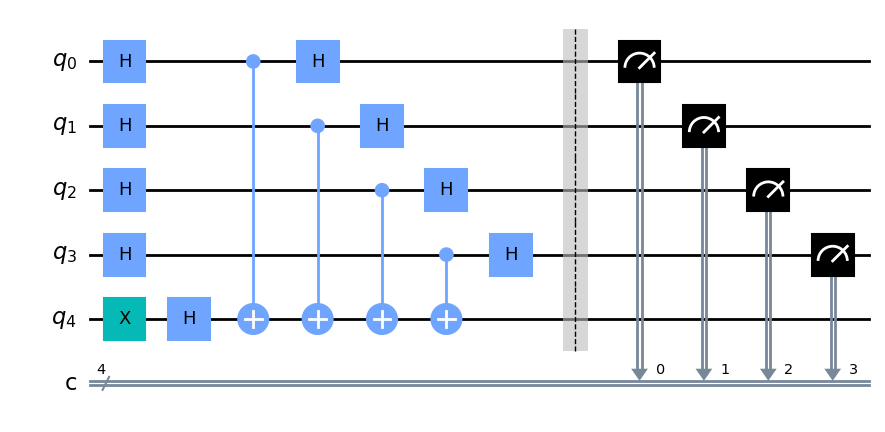

In [3]:
# Perform experiment
bit_range = range(3, 7)

circs = [bv_ones_circs(N+1) for N in bit_range]
trans_circs = transpile(circs, backend, optimization_level=3)

shots = 8192
counts = backend.run(trans_circs, shots=shots).result().get_counts()

display(circs[len(circs) - 3].draw())

In [4]:
# Process Raw results (no mitigation)
raw_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(counts[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    raw_success_probs.append(max_value/shots)

print (raw_success_probs)

[0.9486083984375, 0.9130859375, 0.86083984375, 0.888671875]


In [12]:
# M3 mitigation
mit = mthree.M3Mitigation(backend)
mappings = mthree.utils.final_measurement_mapping(trans_circs)

# calibration
start       = time()
mit.cals_from_system(mappings)
end         = time()
print(f'M3 mitigation calibration time (ms): {(end - start)*1000:.2f}')

#print (mappings[:3])
start       = time()
quasis = mit.apply_correction(counts, mappings)
end         = time()

print(f'M3 mitigation correction time (ms): {(end - start)*1000:.2f}')

# Get the mitigated success probability, validating that our returned bit-string is what we expect.
mit_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit_success_probs.append(max_value)

print (mit_success_probs)

M3 mitigation calibration time (ms): 670.00
M3 mitigation correction time (ms): 0.00
[0.973063750026482, 0.9452391691697638, 0.9177258766213892, 0.9343698541289306]


We follow the test carefully, only altering the test code to insert the filter mitigation technique with intensity ranges of 1% [Input range (0.01, 0.99)] and 2% [Input range (0.02, 0.98)].

In [13]:
# filter mitigatiom with various ranges
import mitigation as mitigation

# low mitigation (type image)
in_range0 = 'image'
quasis0 = mitigation.get_probabilities(counts, shots, in_range = in_range0)
mit0_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis0[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit0_success_probs.append(max_value)

# 1% mitigation
in_range1 = (0.01, 0.99)

start       = time()
quasis1 = mitigation.get_probabilities(counts, shots, in_range = in_range1)
end       = time()

print(f'Filter @ 1% mitigation execution time (ms): {(end - start)*1000:.2f}')

mit1_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis1[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit1_success_probs.append(max_value)

# 2% mitigation
in_range2 = (0.02, 0.98)
quasis2 = mitigation.get_probabilities(counts, shots, in_range = in_range2)
mit2_success_probs = []

for idx, num_bits in enumerate(bit_range):
    max_bitstring, max_value = most_likely_bitstring(quasis2[idx])
    if max_bitstring != '1'*num_bits:
        raise Exception('Returned wrong bit-string')
    mit2_success_probs.append(max_value)

print (str(in_range0) + ' = ' + str(mit0_success_probs))
print (str(in_range1) + ' = ' + str(mit1_success_probs))
print (str(in_range2) + ' = ' + str(mit2_success_probs))

Filter @ 1% mitigation execution time (ms): 0.00
image = [0.9502201565557729, 0.9155239960822723, 0.8636697697207253, 0.8914880587875078]
(0.01, 0.99) = [0.9843509163624073, 0.9623643884798502, 0.9289129843752498, 0.9773838232418693]
(0.02, 0.98) = [1.0, 0.9899652518429514, 0.9718332910070826, 0.9994157565952092]


The results show the intensity filter technique outperforming M3 by a solid margin for a 2% intensity level; even at 1% it produces better results. Furthermore, due to its simplicity, image manipulation filtering performs faster than the system of linear equations used by M3. 

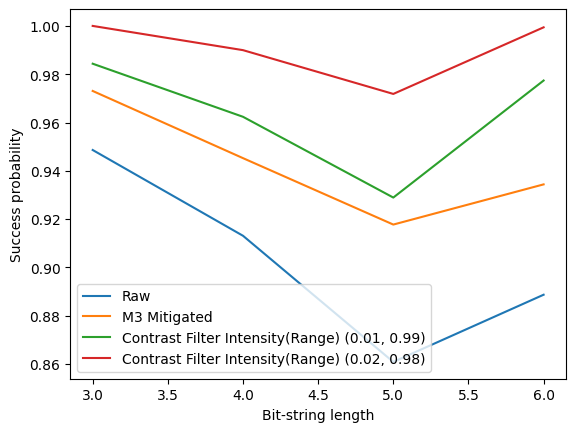

In [14]:
# Plot results
fig, ax = plt.subplots()

ax.plot(bit_range, raw_success_probs, label='Raw')
ax.plot(bit_range, mit_success_probs, label='M3 Mitigated')
#ax.plot(bit_range, mit0_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range0))
ax.plot(bit_range, mit1_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range1))
ax.plot(bit_range, mit2_success_probs, label='Contrast Filter Intensity(Range) ' + str(in_range2))

ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();